# 1. Setting up

In [ ]:
# installing the enviorment

!pip install highway-env
!pip install gym

#installing reinforcement learning libraries

!pip install stable-baselines3[extra]
!pip install tensorflow==2.3.0
!pip install keras
!pip install keras-rl2

#installing visual helpers

%load_ext tensorboard
%pip install pyvirtualdisplay
%matplotlib inline
!apt install -y python-opengl ffmpeg > /dev/null 2>&1

In [1]:
#importing libraries, that are needed for the project

#General libraries
import os
import sys
import random

#Discrete math
import numpy as np

#Gym and environment
import gymnasium as gym
import highway_env

#Tensorflow libraries for 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

#Reinforcement learning
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Visualization
import pprint
from matplotlib import pyplot as plt, animation
from IPython import display

#Stable-baselines3 parts (currently not needed)

#from stable_baselines3 import DQN, PPO, A2C
#from stable_baselines3.common.evaluation import evaluate_policy
#from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
#from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper


# 2. Getting familiar with the environment: testing, sampling

In [2]:
#Init the environment

env = gym.make('highway-v0')

C:\Users\yolom\anaconda3\envs\projektmunka\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [5]:
#A lots of sampling, getting familiar with the enviorment

#Configurations

pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


In [8]:
#type of action space

env.action_space

Discrete(5)

In [9]:
#example of an action 

env.action_space.sample()

2

In [12]:
#Possible actions
#        0: 'LANE_LEFT',
#        1: 'IDLE',
#        2: 'LANE_RIGHT',
#        3: 'FASTER',
#        4: 'SLOWER' 

env.get_available_actions()

[1, 0, 3, 4]

In [13]:
#type of observation space (5*5 matrix of float32)
    
env.observation_space

Box(-inf, inf, (5, 5), float32)

In [14]:
#example of observation space state

env.observation_space.sample()

array([[-0.52325255, -1.632205  ,  0.4592215 , -0.50759214,  0.25303552],
       [-0.78591305,  1.0128678 , -0.72311825,  1.8285061 ,  0.06625871],
       [ 1.7542125 , -1.9930159 ,  0.6939964 , -0.93511456, -0.28286204],
       [-1.4933485 ,  1.2052554 ,  0.72150165,  0.39174706, -0.35166866],
       [-0.1693636 ,  0.8929746 , -0.7449813 ,  0.05278452,  0.99597836]],
      dtype=float32)

# 3. Visualization

In [3]:
#functions and class to realize animations

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)



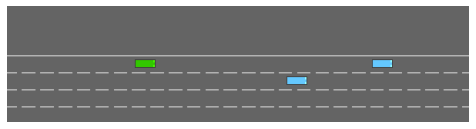

In [5]:
obs, info = env.reset()
done = truncated = False
frames = []
env.reset()

while not (done or truncated):
    action = random.choice([0,4])
    frames.append(env.render(mode='rgb_array'))
    obs, reward, done, truncated, info = env.step(action)
env.close()
display.HTML(display_anim(frames))

# 4. Building the learning agent

In [19]:
#DLR model builder function

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [20]:
#DQN agent builder function

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn


In [21]:
#creating the enviorment + states + actions for DLR

env = gym.make('highway-v0')
states = env.observation_space.shape[0]
actions = env.action_space.n
actions

C:\Users\yolom\anaconda3\envs\projektmunka\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


5

In [22]:
model = build_model(states, actions)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 24)                144       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 5)                 125       
                                                                 
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


# 5. Fitting (to be continued)

In [25]:
#Declaring and fitting DQN agent (fitting throws error for now)

dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
#dqn.fit(env, nb_steps=50000, verbose=1)

In [57]:
#-----------------------------------------Testing with stable-baselines3--------------------------------------------------------

#Defining logging

#log_path = os.path.join('Training', 'Logs')
#log_path



In [33]:
#env=gym.make('highway-fast-v0')
#env.reset()

#print(type(env))

#A2C, PPO and DQN all throw error in these cases

#model = A2C("MlpPolicy", env, verbose=1)
#model = PPO("MlpPolicy", env, verbose=1)
#model = DQN('MlpPolicy', env, verbose = 1)

#model.learn(total_timesteps=30000)
